In [1]:
import pandas as pd
import numpy as np
import random;import copy
import sys;import time
import matplotlib.pyplot as plt

In [2]:
genomesize = 500
gens = 100
popsize = 100
DNAcharacters = 'TGCA'

In [3]:
times = []
sizes = []
ave_scores = []
max_scores = []
max_iterations = []
ave_mutations = []
max_mutations = []

In [4]:
def crossover_rate():
        random.seed(17)
        crossover_rate = random.uniform(0,9)
        return crossover_rate
    
    
def mutation_rate():
        #random.seed(17)
        mutation_base = random.uniform(2,4)
        mutation_pressure = random.uniform(0,1)
        mutation_rate = mutation_base - mutation_pressure
        #mutation_rate = random.uniform(1,(gens/2)/i)
        return mutation_rate

In [7]:
class individual:
    def __init__(self):
        self.fitness = 0
        self.genome = []
        random.seed(17)
        for i in range(0,genomesize):
            self.genome.append(random.choice(DNAcharacters))
        self.calcFitness2()

    def print(self):
        for c in self.genome:
            print(c,end = "")
        print("  fitness:" + str(self.fitness))
    
    def calcFitness2(self):
        #total = len(self.genome)
        self.fitness = 0
        for i in range(len(self.genome)-1):
            if i + 1 < len(self.genome) and self.genome[i] == 'C' and self.genome[i+1] == 'G':
                self.fitness += 1
        return self.fitness/popsize
    
    def mutation(self,mutation_rate):
        for i in range(0,genomesize):
            if(random.uniform(0,100) < mutation_rate):
                self.genome[i] = random.choice(DNAcharacters)
                #mutations.append(mutation_rate)
        self.calcFitness2()

    def copy(self,source):
        self.fitness = source.fitness
        for i in range(0,genomesize):
            self.genome[i] = source.genome[i]

In [8]:
class population:
    def __init__(self):  
        self.avg_fitness = 0
        self.the_pop = []
        for i in range(0,popsize):
            self.the_pop.append(individual())

    def calcstats(self):
        self.avg_fitness = 0
        for i in self.the_pop:
            self.avg_fitness += i.fitness
        self.avg_fitness /= popsize
        
        
    def generationalElite(self,mutation_rate):
        tempPop = population()
        for i in range(0,popsize,2):
            self.the_pop.sort(key=lambda x: x.fitness, reverse=True)
            parent1 = 0 
            parent2 = 1
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.twopoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        
    def generational1(self,mutation_rate):  # tournament + uniform crossover
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.tournament()
            parent2 = self.tournament()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.uniform_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        
    def generational2(self,mutation_rate): # tournament + onepoint crossover
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.tournament()
            parent2 = self.tournament()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.onepoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        
        
    def generational3(self,mutation_rate): # tournament + twopoint crossover
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.tournament()
            parent2 = self.tournament()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.twopoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()

    def generational_roulette(self,mutation_rate):
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.roulette()
            parent2 = self.roulette()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.onepoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        
# selection methods ************************************        
        
    def tournament(self):
        tourn_size = 2
        best_so_far = random.randint(0,popsize-1)
        best_fitness = self.the_pop[best_so_far].fitness
        for i in range(0,tourn_size - 1):
            current = random.randint(0,popsize-1)
            current_fit = self.the_pop[current].fitness
            if(current_fit > best_fitness):
                best_so_far = current
                best_fitness = current_fit
        return best_so_far
    
    
    def roulette(self):  #fitness proportionate selection with default to elite or uniform
        self.the_pop.sort(key=lambda x: x.fitness, reverse=True)
        fit_values = [individual.fitness for individual in self.the_pop]
        #print(fit_values)
        max_fit = max(fit_values)
        sum_fit = sum(fit_values)
        probs = [fit/sum_fit for fit in fit_values]
        U = random.uniform(0, 1)
        C = 0
        for i, prob in enumerate(probs):
            C += prob
            if C > U:
                return i
        #return popsize[0]
        #return popsize[d]

    
    
# crossover methods **************************************    
    
    def uniform_crossover(self,p1,p2):
        crossover_rate = random.uniform(0,9)
        for j in range(0,genomesize):
            if random.randint(0,100) < crossover_rate:
                temp = self.the_pop[p1].genome[j]
                self.the_pop[p1].genome[j] = self.the_pop[p2].genome[j]
                self.the_pop[p2].genome[j] = temp
    
    def onepoint_crossover(self,p1,p2):
        crossover_point = random.randint(0,genomesize)
        for j in range(crossover_point, genomesize):
            temp = self.the_pop[p1].genome[j]
            self.the_pop[p1].genome[j] = self.the_pop[p2].genome[j]
            self.the_pop[p2].genome[j] = temp
    
    def twopoint_crossover(self,p1,p2):
        position1 = random.randint(0,genomesize)
        position2 = random.randint(0,genomesize)
        for j in range(position1, position2):
            temp = self.the_pop[p1].genome[j]
            self.the_pop[p1].genome[j] = self.the_pop[p2].genome[j]
            self.the_pop[p2].genome[j] = temp

In [9]:
mutations1 = []
g1=[]
ind=[]
p = population()


# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations1.append(mutate*10)
    ind.append(i)
    p.generational1(mutate)
    g1.append(p.avg_fitness) 
end_time = time.time()
#****************************************


times.append(end_time - start_time)
sizes.append(sys.getsizeof(g1))
max_scores.append(max(g1))
max_iterations.append(g1.index(max(g1)))
ave_scores.append(np.mean(g1))
ave_mutations.append(np.mean(mutations1))
max_mutations.append(max(mutations1))

print("Mutation max:",np.round(max(mutations1)))
print("Mutation average:",np.round(np.mean(mutations1)))

print("Max Fitness Score for Tourament w/ Uniform Crossover: ",max(g1))
#print("Max Fitness Score2:",max(max_scores1))

print("Time elapsed: ", np.round(end_time - start_time))
print("g1 size in bytes: ", sys.getsizeof(g1))
print("Maximum score was attained at iteration: ", g1.index(max(g1)))

best1 = g1.index(max(g1))
p.the_pop[best1].print()

Mutation max: 32.0
Mutation average: 23.0
Max Fitness Score for Tourament w/ Uniform Crossover:  73.23
Time elapsed:  7.0
g1 size in bytes:  920
Maximum score was attained at iteration:  96
CACCCGCCGGCGCGAGTAGTGAACAGAGTCTACGTCCGTAACTGCTATCGCTACGGCTCGCTCCTCATTCTCACGTACTTCCCTTGCCGTGACATAACAAAGTGGACGCGCGACAAGGAACCGGCCGTCGGGTATAGTAGACAGAGGATTCGACGGCGCGCGCAGCATCTCACCATAAGACGCGCTCCGGAAACCTTCGGCGCGCTAAAAGGCTCTCGACGCGATCGACTCGACACACGCCAGGGCACTAGGTCAGACGAGCGATCGCGCGCCGTCGGCTTCGGCGGTATCGCGACTTCCGCACAAATTAGCCGCTAAGAGAACCGTCACTAGAAAACGTTTAACCTCGCGTCGTAGCGTGCGCTTTAGAGAAAATTTGCGGCGCGGTATGCACTCAATAGGCTTTGCTAGATACACGCGTTGTAGCGTTGTCGCGCTGTCACCGTCGTCCGATTTCGACGGAGTATCAAGACCGGTGCGTTATGTATACACGCGCCGAC  fitness:72


In [10]:
mutations2 = []
max_iterations2 = []
g2=[]
ind=[]
p = population()


# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations2.append(mutate*10)
    ind.append(i)
    p.generational2(mutate)
    g2.append(p.avg_fitness) 
end_time = time.time()
#****************************************


times.append(end_time - start_time)
sizes.append(sys.getsizeof(g2))
max_scores.append(max(g2))
max_iterations.append(g2.index(max(g2)))
ave_scores.append(np.mean(g2))
ave_mutations.append(np.mean(mutations2))
max_mutations.append(max(mutations2))

print("Mutation max:",max(mutations2))
print("Mutation average:",np.mean(mutations2))

print("Max Fitness Score:",max(g2))
#print("Max Fitness Score2:",max(max_scores1))

print("Time elapsed: ", end_time - start_time)
print("g1 size in bytes: ", sys.getsizeof(g2))
print("Maximum score was attained at iteration: ", g2.index(max(g2)))

best2 = g2.index(max(g2))
p.the_pop[best2].print()

Mutation max: 32.01676785223997
Mutation average: 27.6837071453699
Max Fitness Score: 79.36
Time elapsed:  5.846633434295654
g1 size in bytes:  920
Maximum score was attained at iteration:  98
TAGCGATTCAAAATTATCGTCCGGTGCGTAACTGCTGAGATTATCGACGGACGCCGGCCATTGTGATCGCTGATGGCACATGACTCGCAAAACCCCGCGCGGCCTCCACCCGTGCCGTTGGCGAAATTGTCCAGCGCTGCAGAGACGAACAGCCTACCGTGATCGCAAATTGCATACGCCGGGTGCAGGCCACCGCGGAAGACGCTAACACTCTGAGAGCACTCCGGGCGTGTCGGTCCGACGACGTGGTTGGCCCGACCCGCTCGGCCGTATCGATTACGACGCGTGTTGTATTGGCGCAGAAGCGACGGAGCGCATCGGCGCGGTCTGAGTCCGAACCCCGTTCGAGACACCAATTACCGGCTCCAGCGGCACGACGAGCCCGTATACATCGAGCAGCCGCCGTATACGTGCGGCGGCGCGCGCGTGACGCGATCGTTCGCCGAGGGACGTCGTCTTGTGCCGTCGAGTGGAGACGGGGCATTAGCGTGGACGACGAG  fitness:77


In [12]:
mutations3 = []
max_iterations3 = []
g3=[]
ind=[]
p = population()


# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations3.append(mutate*10)
    ind.append(i)
    p.generational3(mutate)
    g3.append(p.avg_fitness) 
end_time = time.time()
#****************************************


times.append(end_time - start_time)
sizes.append(sys.getsizeof(g3))
max_scores.append(max(g3))
max_iterations.append(g3.index(max(g3)))
ave_scores.append(np.mean(g3))
ave_mutations.append(np.mean(mutations3))
max_mutations.append(max(mutations3))


print("Mutation max:",max(mutations3))
print("Mutation average:",np.mean(mutations3))

print("Max Fitness Score:",max(g3))
#print("Max Fitness Score2:",max(max_scores1))

print("Time elapsed: ", end_time - start_time)
print("g1 size in bytes: ", sys.getsizeof(g3))
print("Maximum score was attained at iteration: ", g3.index(max(g3)))

best3 = g3.index(max(g3))
p.the_pop[best3].print()

Mutation max: 34.287422101308245
Mutation average: 26.580877501089017
Max Fitness Score: 80.55
Time elapsed:  5.749417066574097
g1 size in bytes:  920
Maximum score was attained at iteration:  95
GGGCGACGCTCGGCTCTGGTTCTGTGGGAGCGCGGCAGCCGCGGTCGGCGGACGTCCCGGGCTCATGGATTCTTCTGTCGGACTGTAAATCGAATAACGTACCGCACGGCTATTTCGGAACCCGCGCTGACGCGGTCGACGCAAACTGTTCGGGGACCACGCCGCCTCAGGCGCACTGACGAACAGCGCACACAGGGCGGCGCGCGGCGCTCCGTCAGGTAACCCGGGCGCATGCGAACGTCGCACCCGTACAGGCGTCGCGGGACGCGCGACTCCTCGGTGTAGCGCGCAACACGAGGGAAAAACTCGAGCGCTTACGGCCCTGAACCGGCAGGTACCTGCGATCCCTTCCGTCCTATGCGCGCATGCCTCGCGAGAGAAACGCTGCCCGAAGTCCCATTCGGTCATTGTCGCGACGACGCAGCGCTTCTAACGAGGCAGTCCCTGTGCGATCGCGCTTGCGTGCGATGACGCGGTTGTAATCGTACGGGACCGCGGCC  fitness:81


In [13]:
mutations4 = []
max_iterations4 = []
g4=[]
ind=[]
p = population()


# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations4.append(mutate*10)
    ind.append(i)
    p.generational_roulette(mutate)
    g4.append(p.avg_fitness) 
end_time = time.time()
#****************************************


times.append(end_time - start_time)
sizes.append(sys.getsizeof(g4))
max_scores.append(max(g4))
max_iterations.append(g4.index(max(g4)))
ave_scores.append(np.mean(g4))
ave_mutations.append(np.mean(mutations4))
max_mutations.append(max(mutations4))


print("Mutation max:",max(mutations4))
print("Mutation average:",np.mean(mutations4))

print("Max Fitness Score:",max(g4))
#print("Max Fitness Score2:",max(max_scores1))

print("Time elapsed: ", end_time - start_time)
print("g1 size in bytes: ", sys.getsizeof(g4))
print("Maximum score was attained at iteration: ", g4.index(max(g4)))

best4 = g4.index(max(g4))
p.the_pop[best4].print()

Mutation max: 31.775530595599157
Mutation average: 23.84992942806156
Max Fitness Score: 60.48
Time elapsed:  6.029545545578003
g1 size in bytes:  920
Maximum score was attained at iteration:  98
TGTCAAGCTCGGCCCTGGTCTTTCGTGGAGCCGACCCGCGTCCTCCAGCGAGCCGCGAAGGGTGGTTTGCCGCCCCTCAGACTCACGGTGACACGTTGGACGTTACAGGGTCGCTACGCGCGCGTTGGGCGTAGATTAGTTACGCCTTACGGTAGTAGATTCGGGTAGGTTTTCCTAGTCTTACCGACGTCCTAGGCGGAGCGTCTGTTAGCCGCGTCCCGTCGCGACCGATGCTACCCCCCAGAAAAATGACTGAGAGGGGCGCATAGCATTGATATGCGTTTGGTGGACGTGAGGCGACCCGTCTCGGTTTGCGTCCTTGGGTGAGCCGCTCCCCGGTCGGGTCAATGTCGGTGACTGTACCCAGCGGCAAACGAGTAGCGCAATTAACGTGGTCAAATAATTGTCACCAGAAGGCCCTTTGCGCTGTCTTTCGTCCCAGCGAACTCACTCCCGGGTGGCCTACTCGACGGGCGACTCGATCTAAGGGGAGGCATGCC  fitness:54


In [14]:
mutations5 = []
max_iterations5 = []
g5=[]
ind=[]
p = population()


# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations5.append(mutate)
    ind.append(i)
    p.generationalElite(mutate)
    g5.append(p.avg_fitness) 
end_time = time.time()
#****************************************


times.append(end_time - start_time)
sizes.append(sys.getsizeof(g5))


print("Mutation max:",max(mutations5))
print("Mutation average:",np.mean(mutations5))

print("Max Fitness Score:",max(g5))
#print("Max Fitness Score2:",max(max_scores1))

print("Time elapsed: ", end_time - start_time)
print("g1 size in bytes: ", sys.getsizeof(g5))
print("Maximum score was attained at iteration: ", g5.index(max(g5)))

best5 = g5.index(max(g5))
p.the_pop[best5].print()

Mutation max: 3.718503709443122
Mutation average: 2.5941071333770647
Max Fitness Score: 143.56
Time elapsed:  5.671710252761841
g1 size in bytes:  920
Maximum score was attained at iteration:  90
CGCCGCGGGCATCGGCCGAAAAACGCGAGCGCGCGTCGTCGGAGCTCGCGTTCGCGCTCGCGTGCGAGTCGCGGGCGCGGCGCGGCGAACTACGAGGCGTCGACGGAAACGCTTCCGCGACGGCGCGACCGACCCGGCGACGCTACGACCGGCCGAATCCGGATCGTCGGCGGCCCCCGTCGCATACGTACGCCGAGCGTCGGGCGAACGCCCGGCGGCCGCGTGCGCCGGCGCGTCGCGATCACGGCGCGACCGAACGCGCCCCGGTGCAACGCGCGCGGCGGTCCGCGCGCGATTACGTTCACGCGGCGATCTACCGCGCGCGCGTCGTGTGCCCGCGGCGTCGCGCGTCTGTCGCACGCGCGTTCGGAGTCGACGTCGCTTCGCGCCCCGGGGACGACGGCGCGCGCGCGAAACGCTGCGCGCGCGCGCACGAGCGTCGTTTTCGCGCGTGCGGGCGCGCGGACAACCAAGGCGGCCGCGCGGTCGCGCGTGACGAA  fitness:140


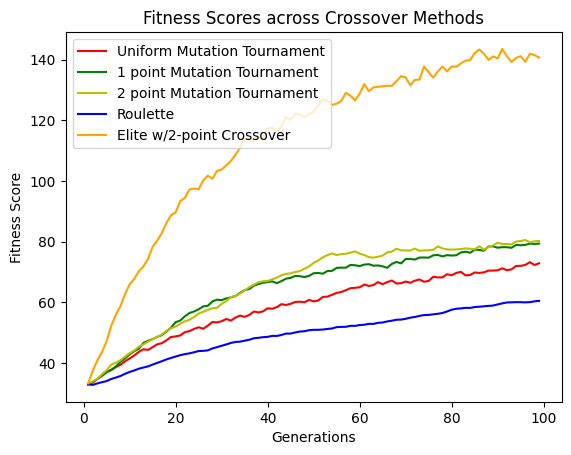

In [15]:
plt.plot(ind, g1, label='Uniform Mutation Tournament', color='r')
plt.plot(ind, g2, label='1 point Mutation Tournament', color='g')
plt.plot(ind, g3, label='2 point Mutation Tournament', color='y')
plt.plot(ind, g4, label='Roulette', color='b')
plt.plot(ind, g5, label='Elite w/2-point Crossover', color='orange')
plt.legend()
plt.title("Fitness Scores across Crossover Methods")
plt.xlabel("Generations")
plt.ylabel("Fitness Score")
plt.show()

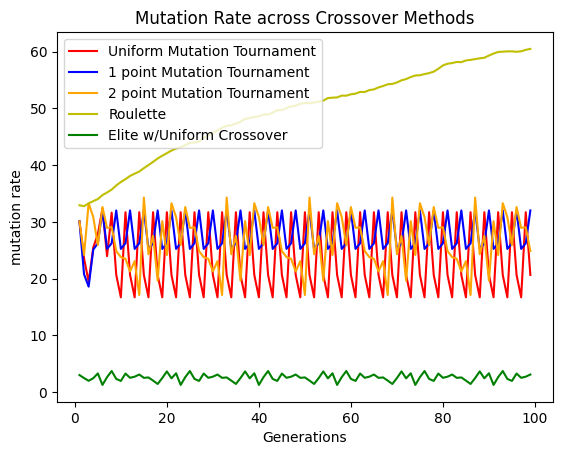

In [16]:
plt.plot(ind, mutations1, label='Uniform Mutation Tournament', color='r')
plt.plot(ind, mutations2, label='1 point Mutation Tournament', color='b')
plt.plot(ind, mutations3, label='2 point Mutation Tournament', color='orange')
plt.plot(ind, g4, label='Roulette', color='y')
plt.plot(ind, mutations5, label='Elite w/Uniform Crossover', color='g')
plt.legend()
plt.title("Mutation Rate across Crossover Methods")
plt.xlabel("Generations")
plt.ylabel("mutation rate")
plt.show()

In [17]:
methods = ['Uniform crossover','1-point crossover','2-point crossover','Roulette','Elitist']
df = pd.DataFrame(list(zip(methods, ave_mutations,max_mutations, ave_scores, max_scores, times, max_iterations)), columns = ['Method', 'mean mutations','max mutations','mean fitness', 'mean score','Time (sec)', 'Max @ Iter'])
df.style.set_caption('Selection Method Comparison')
df.style.set_table_styles([{'selector': 'th', 'props': [('border-bottom', '1px solid black')]}])

,Method,mean mutations,max mutations,mean fitness,mean score,Time (sec),Max @ Iter
0,Uniform crossover,23.300787,32.330593,58.781414,73.230000,7.383639,96
1,1-point crossover,27.683707,32.016768,64.910707,79.360000,5.846633,98
2,2-point crossover,26.580878,34.287422,66.258889,80.550000,5.749417,95
3,Roulette,23.849929,31.775531,49.462828,60.480000,6.029546,98


1st generation code below from class...

In [18]:
seq1 = 'TTAGACTCG'
seq2 = 'TGGAGAATG'
d = -8
sm = [[0 for i in range(0,len(seq1)+1)] for j in range(0,len(seq2)+1)]
print(sm)
sm[1][1]=5
print(sm)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 5, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [ ]:
p = population()
p.the_pop[0].print()
p.the_pop[1].print()
p.onepoint_crossover(0,1)
p.the_pop[1].print()
p.the_pop[0].print()

In [ ]:
p = population()
p.the_pop[0].print()
p.the_pop[1].print()
p.uniform_crossover(0,1)
p.the_pop[1].print()
p.the_pop[0].print()

In [ ]:
for i in range(0,popsize):
    p.the_pop[i].print()
p.calcstats()
print(p.avg_fitness)

In [ ]:
p.generational()

In [ ]:
for i in range(0,popsize):
    p.the_pop[i].print()
p.calcstats()
print(p.avg_fitness)

In [ ]:
p2 = population()
for i in range(0,popsize):
    p2.the_pop[i].print()
p2.calcstats()
print(p2.avg_fitness)
for i in range (0,100):
    p2.generational()
    #print(p2.avg_fitness)
for i in range(0,popsize):
    p2.the_pop[i].print()
p2.calcstats()
print(p2.avg_fitness)